In [ ]:
# Описание:
# Свёрточная нейронная сеть на базе остаточной сети ResNet101
# для классификации чистых и грязных тарелок из датасета Kaggle

# Импорт библиотеки os
import os

# Добавление переменных окружения с определёнными данными
# для загрузки датасета и выгрузки решения
os.environ['KAGGLE_USERNAME'] = "dansow" # username from the json file
os.environ['KAGGLE_KEY'] = "e96d839e740d37e4a59b4b4a1ae0d5ac" # key from the json file

# Загрузка датасета platesv2
! kaggle competitions download -c platesv2

  0% 0.00/8.00k [00:00<?, ?B/s]
100% 8.00k/8.00k [00:00<00:00, 3.20MB/s]
 85% 40.0M/47.1M [00:00<00:00, 45.4MB/s]
100% 47.1M/47.1M [00:00<00:00, 79.2MB/s]


In [ ]:
import numpy as np 
import pandas as pd 

for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/sample_submission.csv
/content/plates.zip
/content/.config/.last_opt_in_prompt.yaml
/content/.config/gce
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/config_sentinel
/content/.config/active_config
/content/.config/configurations/config_default
/content/.config/logs/2021.11.18/14.35.57.849518.log
/content/.config/logs/2021.11.18/14.35.58.667492.log
/content/.config/logs/2021.11.18/14.34.49.152157.log
/content/.config/logs/2021.11.18/14.35.36.918574.log
/content/.config/logs/2021.11.18/14.35.29.959577.log
/content/.config/logs/2021.11.18/14.35.09.738473.log
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_train.csv


In [ ]:
# Импорт всех необходимых библиотек

import shutil
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50, MobileNetV2, ResNet101
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img

import cv2

In [ ]:
# Распаковка архива с изображениями
! unzip -o plates.zip  

Archive:  plates.zip
   creating: plates/
  inflating: plates/.DS_Store        
   creating: __MACOSX/
   creating: __MACOSX/plates/
  inflating: __MACOSX/plates/._.DS_Store  
   creating: plates/test/
  inflating: plates/test/0071.jpg    
  inflating: plates/test/0717.jpg    
  inflating: plates/test/0703.jpg    
  inflating: plates/test/0065.jpg    
  inflating: plates/test/0059.jpg    
  inflating: plates/test/0515.jpg    
  inflating: plates/test/0273.jpg    
  inflating: plates/test/0267.jpg    
  inflating: plates/test/0501.jpg    
  inflating: plates/test/0529.jpg    
  inflating: plates/test/0298.jpg    
  inflating: plates/test/0461.jpg    
  inflating: plates/test/0307.jpg    
  inflating: plates/test/0313.jpg    
  inflating: plates/test/0475.jpg    
  inflating: plates/test/0449.jpg    
  inflating: plates/test/0105.jpg    
  inflating: plates/test/0663.jpg    
  inflating: plates/test/0677.jpg    
  inflating: plates/test/0111.jpg    
  inflating: plates/test/0139.jpg    


In [ ]:
# Создание папок data_augment и data_test
if (os.path.exists('data_augment')):
    shutil.rmtree('data_augment')
if (os.path.exists('data_test')):
    shutil.rmtree('data_test')

os.makedirs('data_augment/plates/train/cleaned')
os.makedirs('data_augment/plates/train/dirty')

os.makedirs('data_test/plates/test')

In [ ]:
# Линейное масштабирование каждого изображения, чтобы иметь среднее значение 0 и дисперсию 1
def image_standardization(img):
    return tf.image.per_image_standardization(img)

# Преобразование каждого изображения в серый цвет
def image_grayscale(img):
    img = np.array(img, dtype=np.uint8)
    img = img[:, :, ::-1]
    
    #img_gray, _ = cv2.decolor(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB)

# Удаление заднего фона
def grabCutFirst(img):

    img = np.array(img, dtype=np.uint8)
    img = img[:, :, ::-1]
    
    height, width = img.shape[:2]
    rect = (15, 15, width-30, height-30)
    
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    output_img = img*mask2[:,:,np.newaxis]  

    background = img - output_img

    background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]

    return cv2.cvtColor(background + output_img, cv2.COLOR_BGR2RGB)

# Обрезка изображения
def crop(img, l):

    img = Image.fromarray(img.astype(np.uint8))
    
    l2 = l // 2     
    w, h = img.size 
    w2 = w // 2     
    h2 = h // 2     
    img = img.crop((w2 - l2, h2 - l2, w2 + l2, h2 + l2))

    img = img.resize((w, h))
    
    return img

# Функция обработки и генерации изображений для тренировки нейронной сети
def image_transform_for_training(org_image_dir_path, crop_size_list, rotation_range):
    
    # ImageDataGenerator 
    datagen = ImageDataGenerator(
           rotation_range=rotation_range,
           width_shift_range=0,
           height_shift_range=0,
           shear_range=0,
           zoom_range=0,
           horizontal_flip=False,
           vertical_flip=False)#,
           #preprocessing_function=image_standardization)
    
    for org_image_file_name in os.listdir(org_image_dir_path):
        
        root, ext = os.path.splitext(org_image_file_name)
        if (ext != '.jpg'):
            continue

        #print('image transform for training : ' + org_image_file_name)
            
        img = image.load_img(org_image_dir_path + '/' + org_image_file_name)
        img = image.img_to_array(img)
        x = grabCutFirst(img)
        # (height, width, 3) -> (1, height, width, 3)
        x = x.reshape((1,) + x.shape)
        
        i = 0
        for d in datagen.flow(x, batch_size=1):
            
            grab_cut_img = grabCutFirst(d[0])
            
            for l in crop_size_list:
                crop_img = image.img_to_array(crop(grab_cut_img, l))
                #std_img = np.array(image_standardization(crop_img))
                std_img = crop_img
                std_img = image_grayscale(std_img)
                save_img('data_augment/' + org_image_dir_path + '/' + root + '_' + str(l) + '_' + str(i * rotation_range) + ext, Image.fromarray(std_img.astype(np.uint8)))
            
            i = i + 1
            if ((360/rotation_range) <= i):
                break

# Функция обработки и генерации изображений для тестирования нейронной сети                
def image_transfrom_for_test(org_image_dir_path, crop_size_list):
    
    for org_image_file_name in os.listdir(org_image_dir_path):

        root, ext = os.path.splitext(org_image_file_name)
        if (ext != '.jpg'):
            continue
    
        #print('image transform for test : ' + org_image_file_name)
    
        img = image.load_img(org_image_dir_path + '/' + org_image_file_name)
        img = image.img_to_array(img)
        img = grabCutFirst(img) 
        
        for l in crop_size_list:

            if (os.path.exists('data_test/' + org_image_dir_path + '/' + str(l)) == False):
                os.makedirs('data_test/' + org_image_dir_path + '/' + str(l))

            crop_img =  image.img_to_array(crop(img, l))
            #std_img = np.array(image_standardization(crop_img))
            std_img = crop_img
            std_img = image_grayscale(std_img)
            save_img('data_test/' + org_image_dir_path + '/' + str(l) + '/' + org_image_file_name,Image.fromarray(std_img.astype(np.uint8)))   

In [ ]:
# Размеры обрезки
crop_size_training_list = [91, 171, 251]
crop_size_test_list = [251]

# Угол поворота изображения для генерации
rotation_range = 90

# Процесс аугментации данных
image_transform_for_training('plates/train/cleaned', crop_size_training_list, rotation_range)
image_transform_for_training('plates/train/dirty', crop_size_training_list, rotation_range)
image_transfrom_for_test('plates/test', crop_size_test_list)

In [ ]:
# Определение основных настроек
image_size = (224, 224)
batch_size = 4
epochs = 30

In [ ]:
# Формирование тренировочного размеченного датасета
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    #plates/train",
    "data_augment/plates/train",
    #labels='inferred', 
    #label_mode='categorical',
    validation_split=0.3,
    subset="training",   
    seed=1307,
    image_size=image_size,
    batch_size=batch_size,
)

# Формирование валидационного размеченного датасета
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    #plates/train",
    "data_augment/plates/train",
    #labels='inferred', 
    #label_mode='categorical',
    validation_split=0.3,
    subset="validation",   
    seed=1307,
    image_size=image_size,
    batch_size=batch_size,
)

Found 480 files belonging to 2 classes.
Using 336 files for training.
Found 480 files belonging to 2 classes.
Using 144 files for validation.


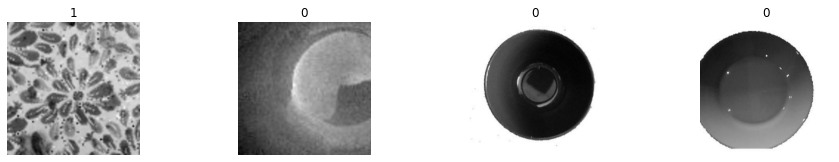

In [ ]:
# Вывод изображений валидационного датасета с метками
plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    for i in range(batch_size):
        ax = plt.subplot(7, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Формирование модели нейронной сети
def get_model():
    # Модель перехода
    input_shape = image_size + (3,)

    # Использование остаточной нейронной сети
    model_res = ResNet101(include_top=False, input_shape=input_shape, weights='imagenet')
    
    # Определение дополнительных слоёв
    x = model_res.output
    
    x = Flatten()(x)

    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dropout(.5)(x)
    
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dropout(.5)(x)
    
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dropout(.5)(x)
    
    x = Dense(1)(x)
    
    outputs = Activation('sigmoid')(x)

    for l in model_res.layers[1:]:
        l.trainable = False
    
    model = Model(model_res.input, outputs)
    
    return model

In [ ]:
# Обучение нескольких моделей
models = {}
models[0] = get_model()
models[1] = get_model()
models[2] = get_model()
#models[3] = get_model()
#models[4] = get_model()
#models[0].summary()

171458560/171446536 [==============================] - 2s 0us/step


In [ ]:
# Функция обучения нейронной сети
def learning(key, model):

    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Компиляция модели с оптимизатором Adam, функцией ошибки binary crossentropy и метрикой binary_accuracy
    model.compile(optimizer=Adam(decay=0.01), loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Определение ранней остановки обучения (если val_loss не улучшает свои показатели 15 эпох)
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=15
    )

    # Параметры сохранения модели (модели сохраняются в папке tmp, сохраняются только лучшие результаты)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        '/tmp/checkpoint_' + str(key), 
        monitor='val_binary_accuracy', 
        save_best_only=True   # val_binary_accuracy
    )

    # Возвращение обученной модели
    return model.fit(
        train_ds,
        validation_data=val_ds, 
        epochs=epochs, 
        callbacks=[callback, checkpoint]
    )

In [ ]:
# Процесс обучения моделей
results = {}
for key, model in models.items():
    print('=== model-' + str(key) + ' fiting ===')
    results[key] = learning(key, model)

=== model-0 fiting ===
Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 15.6505 - binary_accuracy: 0.5268INFO:tensorflow:Assets written to: /tmp/checkpoint_0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 87s 853ms/step - loss: 15.6505 - binary_accuracy: 0.5268 - val_loss: 2.6749 - val_binary_accuracy: 0.6181
Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 8.9997 - binary_accuracy: 0.6488INFO:tensorflow:Assets written to: /tmp/checkpoint_0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 69s 832ms/step - loss: 8.9997 - binary_accuracy: 0.6488 - val_loss: 0.5187 - val_binary_accuracy: 0.8889
Epoch 3/30
84/84 [==============================] - 12s 146ms/step - loss: 5.2627 - binary_accuracy: 0.6994 - val_loss: 0.9158 - val_binary_accuracy: 0.8611
Epoch 4/30
84/84 [==============================] - ETA: 0s - loss: 2.6757 - binary_accuracy: 0.7827INFO:tensorflow:Assets written to: /tmp/checkpoint_0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 69s 830ms/step - loss: 2.6757 - binary_accuracy: 0.7827 - val_loss: 0.2638 - val_binary_accuracy: 0.9444
Epoch 5/30
84/84 [==============================] - ETA: 0s - loss: 1.6991 - binary_accuracy: 0.8363INFO:tensorflow:Assets written to: /tmp/checkpoint_0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 69s 830ms/step - loss: 1.6991 - binary_accuracy: 0.8363 - val_loss: 0.3186 - val_binary_accuracy: 0.9514
Epoch 6/30
84/84 [==============================] - 12s 147ms/step - loss: 1.5132 - binary_accuracy: 0.8720 - val_loss: 0.2363 - val_binary_accuracy: 0.9444
Epoch 7/30
84/84 [==============================] - ETA: 0s - loss: 1.4916 - binary_accuracy: 0.8720INFO:tensorflow:Assets written to: /tmp/checkpoint_0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 70s 839ms/step - loss: 1.4916 - binary_accuracy: 0.8720 - val_loss: 0.1749 - val_binary_accuracy: 0.9653
Epoch 8/30
84/84 [==============================] - 12s 147ms/step - loss: 1.3065 - binary_accuracy: 0.8452 - val_loss: 0.1714 - val_binary_accuracy: 0.9583
Epoch 9/30
84/84 [==============================] - 12s 148ms/step - loss: 0.7309 - binary_accuracy: 0.9048 - val_loss: 0.1749 - val_binary_accuracy: 0.9583
Epoch 10/30
84/84 [==============================] - ETA: 0s - loss: 0.7735 - binary_accuracy: 0.9196INFO:tensorflow:Assets written to: /tmp/checkpoint_0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 71s 851ms/step - loss: 0.7735 - binary_accuracy: 0.9196 - val_loss: 0.1257 - val_binary_accuracy: 0.9722
Epoch 11/30
84/84 [==============================] - 13s 148ms/step - loss: 0.4743 - binary_accuracy: 0.9048 - val_loss: 0.1373 - val_binary_accuracy: 0.9653
Epoch 12/30
84/84 [==============================] - ETA: 0s - loss: 0.7058 - binary_accuracy: 0.9256INFO:tensorflow:Assets written to: /tmp/checkpoint_0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 71s 857ms/step - loss: 0.7058 - binary_accuracy: 0.9256 - val_loss: 0.0850 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 13/30
84/84 [==============================] - ETA: 0s - loss: 0.6348 - binary_accuracy: 0.9167INFO:tensorflow:Assets written to: /tmp/checkpoint_0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 71s 853ms/step - loss: 0.6348 - binary_accuracy: 0.9167 - val_loss: 0.0660 - val_binary_accuracy: 0.9861


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 14/30
84/84 [==============================] - 12s 145ms/step - loss: 0.3851 - binary_accuracy: 0.9256 - val_loss: 0.0664 - val_binary_accuracy: 0.9861
Epoch 15/30
84/84 [==============================] - 12s 144ms/step - loss: 0.9041 - binary_accuracy: 0.9077 - val_loss: 0.0663 - val_binary_accuracy: 0.9861
Epoch 16/30
84/84 [==============================] - 12s 144ms/step - loss: 0.3640 - binary_accuracy: 0.9345 - val_loss: 0.0586 - val_binary_accuracy: 0.9861
Epoch 17/30
84/84 [==============================] - 12s 143ms/step - loss: 0.3359 - binary_accuracy: 0.9345 - val_loss: 0.0876 - val_binary_accuracy: 0.9861
Epoch 18/30
84/84 [==============================] - 12s 144ms/step - loss: 0.2689 - binary_accuracy: 0.9524 - val_loss: 0.0898 - val_binary_accuracy: 0.9861
Epoch 19/30
84/84 [==============================] - 12s 144ms/step - loss: 0.4266 - binary_accuracy: 0.9435 - val_loss: 0.1004 - val_binary_accuracy: 0.9861
Epoch 20/30
84/84 [==============================] -

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 69s 830ms/step - loss: 0.4509 - binary_accuracy: 0.9554 - val_loss: 0.0654 - val_binary_accuracy: 0.9931


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 27/30
84/84 [==============================] - 12s 147ms/step - loss: 0.3048 - binary_accuracy: 0.9524 - val_loss: 0.0821 - val_binary_accuracy: 0.9931
Epoch 28/30
84/84 [==============================] - 12s 145ms/step - loss: 0.1273 - binary_accuracy: 0.9702 - val_loss: 0.0877 - val_binary_accuracy: 0.9931
Epoch 29/30
84/84 [==============================] - 12s 147ms/step - loss: 0.1771 - binary_accuracy: 0.9494 - val_loss: 0.0975 - val_binary_accuracy: 0.9931
Epoch 30/30
84/84 [==============================] - 12s 145ms/step - loss: 0.1148 - binary_accuracy: 0.9732 - val_loss: 0.0764 - val_binary_accuracy: 0.9931
=== model-1 fiting ===
Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 21.8828 - binary_accuracy: 0.5446INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 79s 863ms/step - loss: 21.8828 - binary_accuracy: 0.5446 - val_loss: 0.6472 - val_binary_accuracy: 0.8681
Epoch 2/30
84/84 [==============================] - 12s 145ms/step - loss: 10.9285 - binary_accuracy: 0.6429 - val_loss: 0.7830 - val_binary_accuracy: 0.8681
Epoch 3/30
84/84 [==============================] - ETA: 0s - loss: 4.8415 - binary_accuracy: 0.7262INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 71s 858ms/step - loss: 4.8415 - binary_accuracy: 0.7262 - val_loss: 0.8556 - val_binary_accuracy: 0.8819
Epoch 4/30
84/84 [==============================] - ETA: 0s - loss: 2.9256 - binary_accuracy: 0.7827INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 70s 845ms/step - loss: 2.9256 - binary_accuracy: 0.7827 - val_loss: 0.4573 - val_binary_accuracy: 0.9097
Epoch 5/30
84/84 [==============================] - ETA: 0s - loss: 2.9145 - binary_accuracy: 0.8304INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 70s 846ms/step - loss: 2.9145 - binary_accuracy: 0.8304 - val_loss: 0.3076 - val_binary_accuracy: 0.9236
Epoch 6/30
84/84 [==============================] - ETA: 0s - loss: 1.8298 - binary_accuracy: 0.8690INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 70s 847ms/step - loss: 1.8298 - binary_accuracy: 0.8690 - val_loss: 0.2428 - val_binary_accuracy: 0.9444


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 7/30
84/84 [==============================] - ETA: 0s - loss: 1.3368 - binary_accuracy: 0.8750INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 70s 837ms/step - loss: 1.3368 - binary_accuracy: 0.8750 - val_loss: 0.1870 - val_binary_accuracy: 0.9514


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 8/30
84/84 [==============================] - ETA: 0s - loss: 1.4882 - binary_accuracy: 0.8720INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 70s 843ms/step - loss: 1.4882 - binary_accuracy: 0.8720 - val_loss: 0.1154 - val_binary_accuracy: 0.9653


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 9/30
84/84 [==============================] - ETA: 0s - loss: 0.9625 - binary_accuracy: 0.9077INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 70s 844ms/step - loss: 0.9625 - binary_accuracy: 0.9077 - val_loss: 0.0755 - val_binary_accuracy: 0.9722


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 10/30
84/84 [==============================] - 12s 146ms/step - loss: 0.7820 - binary_accuracy: 0.9196 - val_loss: 0.0906 - val_binary_accuracy: 0.9722
Epoch 11/30
84/84 [==============================] - 12s 145ms/step - loss: 0.8968 - binary_accuracy: 0.9048 - val_loss: 0.1127 - val_binary_accuracy: 0.9514
Epoch 12/30
84/84 [==============================] - 12s 145ms/step - loss: 0.2972 - binary_accuracy: 0.9524 - val_loss: 0.1190 - val_binary_accuracy: 0.9583
Epoch 13/30
84/84 [==============================] - 12s 144ms/step - loss: 0.7398 - binary_accuracy: 0.9077 - val_loss: 0.1275 - val_binary_accuracy: 0.9722
Epoch 14/30
84/84 [==============================] - ETA: 0s - loss: 0.5946 - binary_accuracy: 0.9464INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 71s 857ms/step - loss: 0.5946 - binary_accuracy: 0.9464 - val_loss: 0.1015 - val_binary_accuracy: 0.9792
Epoch 15/30
84/84 [==============================] - 12s 146ms/step - loss: 0.9536 - binary_accuracy: 0.9226 - val_loss: 0.1011 - val_binary_accuracy: 0.9722
Epoch 16/30
84/84 [==============================] - ETA: 0s - loss: 0.5241 - binary_accuracy: 0.9315INFO:tensorflow:Assets written to: /tmp/checkpoint_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 70s 845ms/step - loss: 0.5241 - binary_accuracy: 0.9315 - val_loss: 0.0996 - val_binary_accuracy: 0.9861
Epoch 17/30
84/84 [==============================] - 12s 146ms/step - loss: 0.5257 - binary_accuracy: 0.9464 - val_loss: 0.1362 - val_binary_accuracy: 0.9792
Epoch 18/30
84/84 [==============================] - 12s 146ms/step - loss: 0.5043 - binary_accuracy: 0.9435 - val_loss: 0.1463 - val_binary_accuracy: 0.9792
Epoch 19/30
84/84 [==============================] - 12s 145ms/step - loss: 0.2999 - binary_accuracy: 0.9524 - val_loss: 0.1208 - val_binary_accuracy: 0.9861
Epoch 20/30
84/84 [==============================] - 12s 144ms/step - loss: 0.5011 - binary_accuracy: 0.9345 - val_loss: 0.1231 - val_binary_accuracy: 0.9792
Epoch 21/30
84/84 [==============================] - 12s 145ms/step - loss: 0.3085 - binary_accuracy: 0.9524 - val_loss: 0.1205 - val_binary_accuracy: 0.9792
Epoch 22/30
84/84 [==============================] - 12s 143ms/s

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 78s 854ms/step - loss: 22.7916 - binary_accuracy: 0.5714 - val_loss: 1.6328 - val_binary_accuracy: 0.8333


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 8.8596 - binary_accuracy: 0.7173INFO:tensorflow:Assets written to: /tmp/checkpoint_2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 70s 837ms/step - loss: 8.8596 - binary_accuracy: 0.7173 - val_loss: 1.8490 - val_binary_accuracy: 0.8819
Epoch 3/30
84/84 [==============================] - ETA: 0s - loss: 5.7976 - binary_accuracy: 0.7887INFO:tensorflow:Assets written to: /tmp/checkpoint_2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 71s 850ms/step - loss: 5.7976 - binary_accuracy: 0.7887 - val_loss: 0.8013 - val_binary_accuracy: 0.8958
Epoch 4/30
84/84 [==============================] - ETA: 0s - loss: 3.1447 - binary_accuracy: 0.8423INFO:tensorflow:Assets written to: /tmp/checkpoint_2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 70s 844ms/step - loss: 3.1447 - binary_accuracy: 0.8423 - val_loss: 0.7186 - val_binary_accuracy: 0.9028
Epoch 5/30
84/84 [==============================] - ETA: 0s - loss: 3.0966 - binary_accuracy: 0.8423INFO:tensorflow:Assets written to: /tmp/checkpoint_2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 70s 846ms/step - loss: 3.0966 - binary_accuracy: 0.8423 - val_loss: 0.3514 - val_binary_accuracy: 0.9306


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 6/30
84/84 [==============================] - 12s 146ms/step - loss: 1.1365 - binary_accuracy: 0.9196 - val_loss: 0.2739 - val_binary_accuracy: 0.9236
Epoch 7/30
84/84 [==============================] - ETA: 0s - loss: 1.1938 - binary_accuracy: 0.8988INFO:tensorflow:Assets written to: /tmp/checkpoint_2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 70s 843ms/step - loss: 1.1938 - binary_accuracy: 0.8988 - val_loss: 0.4469 - val_binary_accuracy: 0.9444
Epoch 8/30
84/84 [==============================] - 12s 146ms/step - loss: 1.1275 - binary_accuracy: 0.8958 - val_loss: 0.3291 - val_binary_accuracy: 0.9444
Epoch 9/30
84/84 [==============================] - ETA: 0s - loss: 0.9172 - binary_accuracy: 0.8988INFO:tensorflow:Assets written to: /tmp/checkpoint_2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


84/84 [==============================] - 70s 843ms/step - loss: 0.9172 - binary_accuracy: 0.8988 - val_loss: 0.1449 - val_binary_accuracy: 0.9722
Epoch 10/30
84/84 [==============================] - ETA: 0s - loss: 0.6868 - binary_accuracy: 0.9345INFO:tensorflow:Assets written to: /tmp/checkpoint_2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 71s 850ms/step - loss: 0.6868 - binary_accuracy: 0.9345 - val_loss: 0.1118 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 11/30
84/84 [==============================] - ETA: 0s - loss: 1.0464 - binary_accuracy: 0.9107INFO:tensorflow:Assets written to: /tmp/checkpoint_2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 70s 844ms/step - loss: 1.0464 - binary_accuracy: 0.9107 - val_loss: 0.1058 - val_binary_accuracy: 0.9931


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 12/30
84/84 [==============================] - 12s 146ms/step - loss: 0.7459 - binary_accuracy: 0.9286 - val_loss: 0.1211 - val_binary_accuracy: 0.9653
Epoch 13/30
84/84 [==============================] - 12s 147ms/step - loss: 0.7323 - binary_accuracy: 0.9345 - val_loss: 0.1122 - val_binary_accuracy: 0.9792
Epoch 14/30
84/84 [==============================] - 12s 146ms/step - loss: 0.2631 - binary_accuracy: 0.9702 - val_loss: 0.1555 - val_binary_accuracy: 0.9792
Epoch 15/30
84/84 [==============================] - 12s 146ms/step - loss: 0.3327 - binary_accuracy: 0.9524 - val_loss: 0.1241 - val_binary_accuracy: 0.9792
Epoch 16/30
84/84 [==============================] - 12s 145ms/step - loss: 0.7300 - binary_accuracy: 0.9435 - val_loss: 0.0960 - val_binary_accuracy: 0.9861
Epoch 17/30
84/84 [==============================] - 12s 144ms/step - loss: 0.3591 - binary_accuracy: 0.9494 - val_loss: 0.1242 - val_binary_accuracy: 0.9792
Epoch 18/30
84/84 [==============================] -

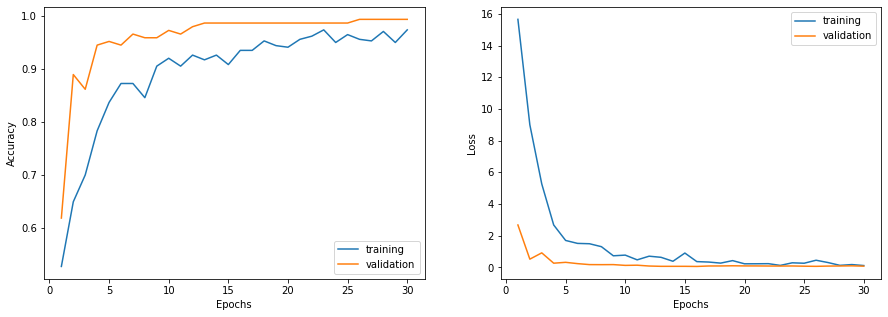

In [ ]:
# Визуализация результатов обучения нейронной сети (на примере результатов первой обученной модели)

result = results[0]
his_range = len(result.history['loss'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, his_range+1), result.history['binary_accuracy'], label="training")
plt.plot(range(1, his_range+1), result.history['val_binary_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, his_range+1), result.history['loss'], label="training")
plt.plot(range(1, his_range+1), result.history['val_loss'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
! ls plates/test/ | head 

0000.jpg
0001.jpg
0002.jpg
0003.jpg
0004.jpg
0005.jpg
0006.jpg
0007.jpg
0008.jpg
0009.jpg


In [ ]:
# Создание генератора тестов
def create_test_generator(l):
    test_datagen = ImageDataGenerator()
    return test_datagen.flow_from_directory(  
        'data_test/plates/test',
        classes=[str(l)],
        target_size = image_size,
        batch_size = 100,
        shuffle = False,        
        class_mode = None)  

In [ ]:
test_generators = {}
for l in crop_size_test_list:
    test_generators[str(l)] = create_test_generator(l)

Found 744 images belonging to 1 classes.


[[1.]]


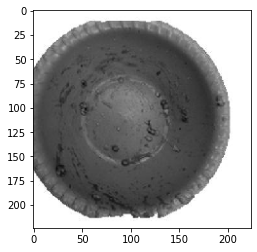

[[1.]]


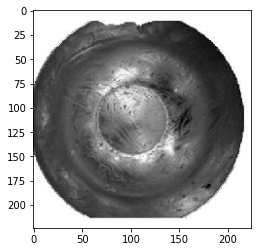

[[0.01336921]]


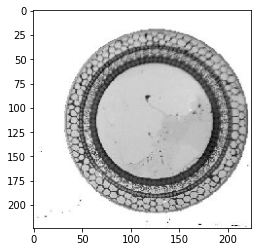

[[1.]]


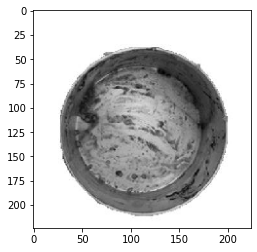

[[1.]]


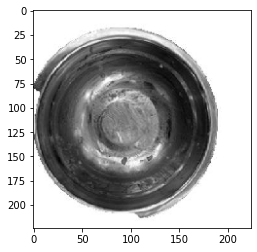

[[1.]]


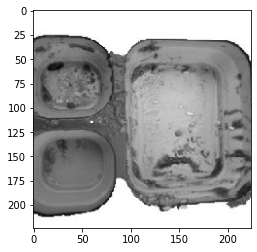

[[1.]]


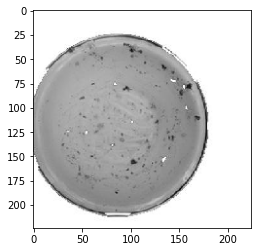

[[1.]]


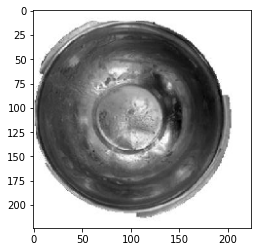

[[1.]]


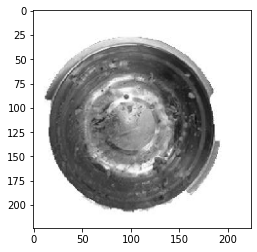

[[0.00040656]]


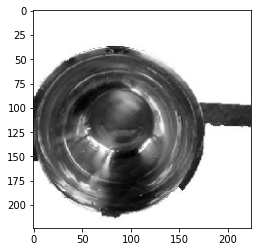

[[1.]]


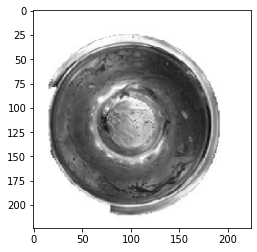

[[1.]]


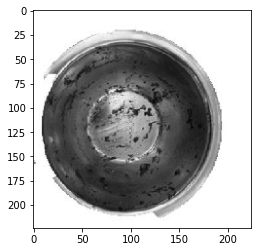

[[9.3127095e-12]]


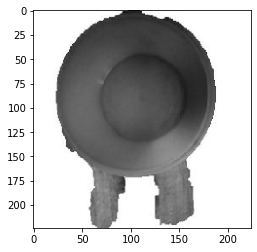

[[1.]]


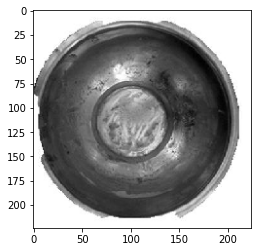

[[8.024819e-14]]


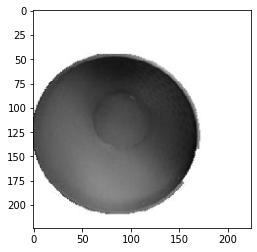

[[1.]]


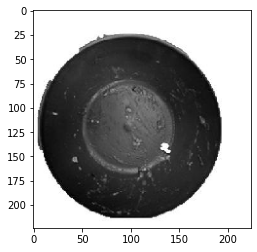

[[0.9993469]]


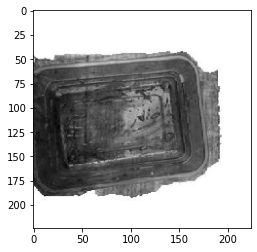

[[1.]]


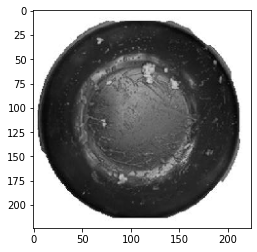

[[1.]]


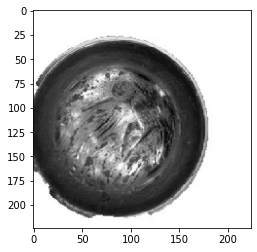

[[1.]]


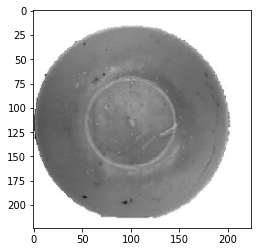

[[1.]]


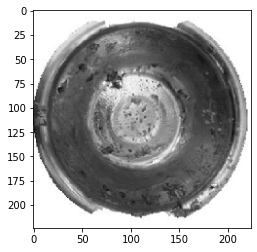

[[1.]]


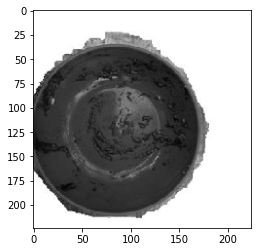

[[1.]]


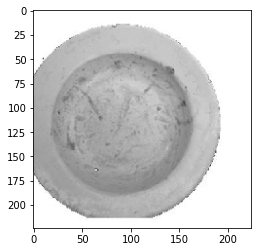

[[1.]]


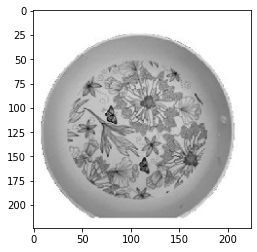

[[1.4329069e-11]]


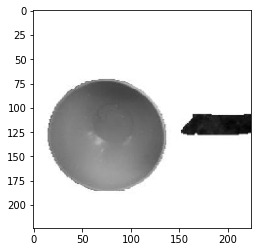

[[1.]]


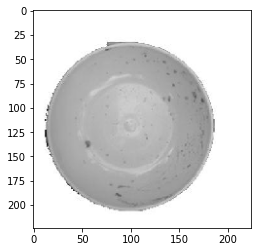

[[6.530142e-11]]


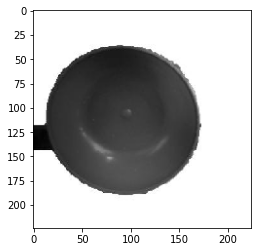

[[4.1747673e-05]]


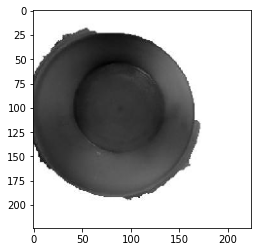

[[0.0223663]]


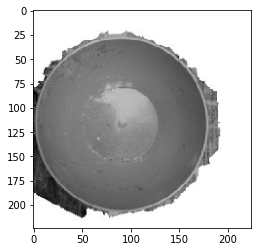

[[1.]]


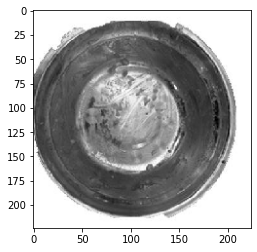

In [ ]:
# Тестирование первой обученной модели
# Смысл показателей: возвращаемое значение
# функции predict модели означает вероятность
# загрязнения тарелки. Если вероятность > 0.5, то 
# тарелка является грязной, иначе - тарелка чистая
model = models[0]

test_generator = test_generators[str(crop_size_test_list[0])]
test_generator.reset()

for d in test_generator:
    for i in range(30):
        print(model.predict([d[i][None,...]]))
        plt.imshow(d[i].astype(np.uint8))
        plt.show()
    break

In [ ]:
# Предсказания каждой модели
predicts = {}
for key, model in models.items():
    for key_gen, test_generator in test_generators.items():
        test_generator.reset()
        predicts['model:' + str(key) + ' - inputsize:' + str(key_gen)] = pd.Series(
            np.ravel(
                model.predict_generator(
                    test_generator, 
                    steps = len(test_generator.filenames)
                )
            )
        )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


In [ ]:
# Вывод результатов предсказаний обученных моделей (первые 30)
predicts_df = pd.DataFrame(predicts)
predicts_df.head(30)

,model:0 - inputsize:251,model:1 - inputsize:251,model:2 - inputsize:251
0,1.000000e+00,1.000000e+00,1.000000e+00
1,1.000000e+00,1.000000e+00,1.000000e+00
2,1.336971e-02,1.848401e-04,6.962656e-08
3,1.000000e+00,9.999999e-01,1.000000e+00
4,1.000000e+00,9.998758e-01,1.000000e+00
5,1.000000e+00,1.000000e+00,1.000000e+00
6,1.000000e+00,1.000000e+00,1.000000e+00
7,1.000000e+00,1.000000e+00,1.000000e+00
8,1.000000e+00,9.999981e-01,1.000000e+00
9,4.065648e-04,1.293287e-08,1.582991e-03


In [ ]:
# Считывание примера файла решения
sub_df = pd.read_csv('../content/sample_submission.csv')

In [ ]:
# Определение lambda функции для формирования
# содержимого файла решения

f = lambda x: 'dirty' if x > 0.5 else 'cleaned'
sub_df['label'] = pd.DataFrame(
    np.mean(
        predicts_df, 
        axis=1
    )
)

# Формирование содержимого файла решения
sub_df['label'] = sub_df['label'].apply(f)

# Вывод в табличном виде результатов работы моделей нейронной сети
sub_df.head(30)

,id,label
0,0,dirty
1,1,dirty
2,2,cleaned
3,3,dirty
4,4,dirty
5,5,dirty
6,6,dirty
7,7,dirty
8,8,dirty
9,9,cleaned


In [ ]:
sub_df['label'].value_counts()

dirty      510
cleaned    234
Name: label, dtype: int64

In [ ]:
# Запись данных в файл решения
sub_df.to_csv('submission.csv', index=False)

In [ ]:
# Отправка файла решения в задание на Kaggle
!kaggle competitions submit -c platesv2 -m "Neural Network" -f submission.csv

100% 7.62k/7.62k [00:01<00:00, 6.41kB/s]
Successfully submitted to Cleaned vs Dirty V2

In [ ]:
# Импорт библиотек для загрузки и вывода изображения
from google.colab import files
from IPython.display import Image


In [ ]:
# Загрузка изображения
uploaded = files.upload()

Saving ressssss.png to ressssss.png


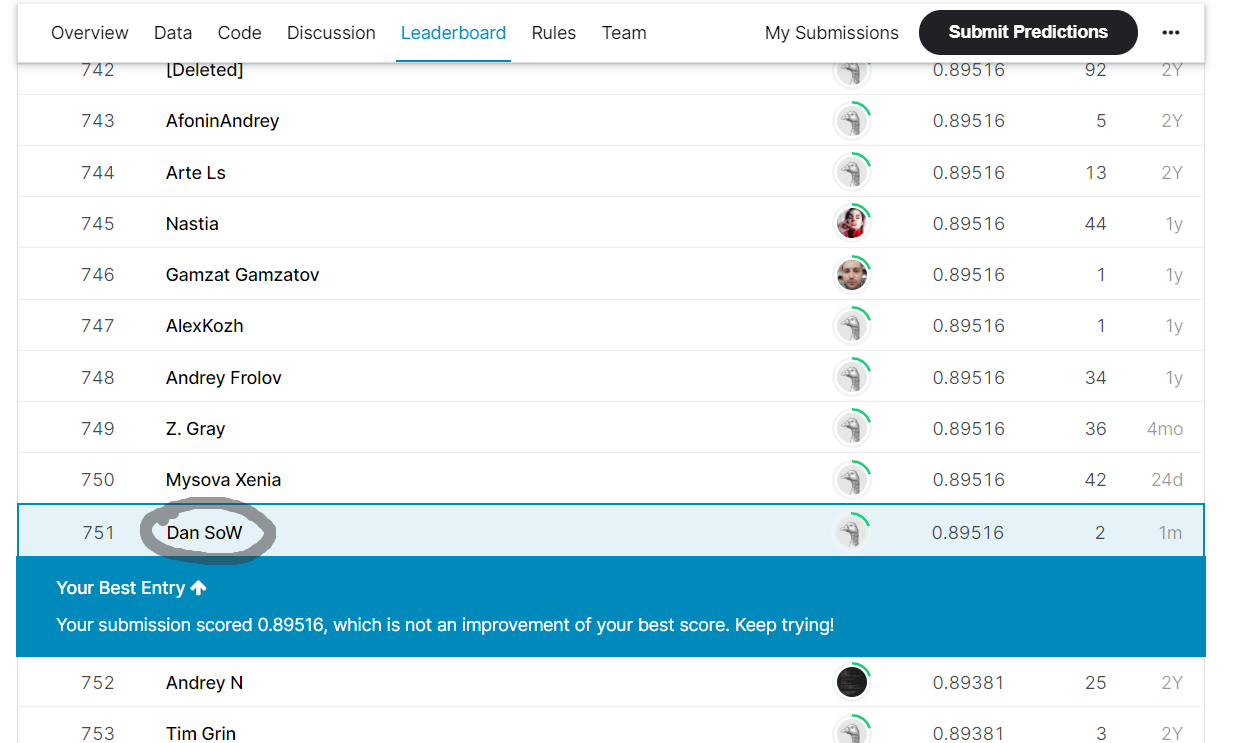

In [ ]:
# Вывод изображения
Image('ressssss.png')